<a href="https://colab.research.google.com/github/riccardorampon/LANL-Earthquake-Prediction/blob/main/Earthquake_Acustic.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [5]:
#to access kaggle datasets
!pip install kaggle
#Math operations
!pip install numpy
#Machine learning
!pip install catboost

In [6]:
#data preprocessing
import pandas as pd
#math operations
import numpy as np
#machine learning
from catboost import CatBoostRegressor, Pool
#data scaling
from sklearn.preprocessing import StandardScaler
#hyperparameter optimization
from sklearn.model_selection import GridSearchCV
#support vector machine model
from sklearn.svm import NuSVR, SVR
#kernel ridge model
from sklearn.kernel_ridge import KernelRidge
#data visualization
import matplotlib.pyplot as plt

In [7]:
# Colab's file access feature
from google.colab import files

#retrieve uploaded file
uploaded = files.upload()

#print results
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [8]:
#list competitions
!kaggle competitions list

ref                                                       deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
mpetitions/contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         35           False  
mpetitions/gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        131           False  
mpetitions/store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge       1372           False  
mpetitions/tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        174           False  
mpetitions/digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2128           False  
mpetitions/titanic                                     

In [9]:
#download earthquake data, will take 30-60 seconds
!kaggle competitions download -c LANL-Earthquake-Prediction

 99% 2.26G/2.27G [00:22<00:00, 145MB/s]
100% 2.27G/2.27G [00:22<00:00, 110MB/s]


In [14]:
#unzip training data for usage, will take about 5 minutes (its big)
!unzip LANL-Earthquake-Prediction.zip


Archive:  LANL-Earthquake-Prediction.zip
  inflating: sample_submission.csv   
  inflating: test/seg_00030f.csv     
  inflating: test/seg_0012b5.csv     
  inflating: test/seg_00184e.csv     
  inflating: test/seg_003339.csv     
  inflating: test/seg_0042cc.csv     
  inflating: test/seg_004314.csv     
  inflating: test/seg_004cd2.csv     
  inflating: test/seg_004ee5.csv     
  inflating: test/seg_004f1f.csv     
  inflating: test/seg_00648a.csv     
  inflating: test/seg_006e4a.csv     
  inflating: test/seg_007a37.csv     
  inflating: test/seg_00a37e.csv     
  inflating: test/seg_00be11.csv     
  inflating: test/seg_00c35b.csv     
  inflating: test/seg_00cc91.csv     
  inflating: test/seg_00e5f7.csv     
  inflating: test/seg_00f3b9.csv     
  inflating: test/seg_010eab.csv     
  inflating: test/seg_0125d9.csv     
  inflating: test/seg_0144cb.csv     
  inflating: test/seg_0165c6.csv     
  inflating: test/seg_016913.csv     
  inflating: test/seg_016cdb.csv     
  inflati

In [16]:
#Extract training data into a dataframe for further manipulation
train = pd.read_csv('train.csv', nrows=6000000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

#print first 10 entries
train.head(10)

,acoustic_data,time_to_failure
0,12,1.4691
1,6,1.4691
2,8,1.4691
3,5,1.4691
4,8,1.4691
5,8,1.4691
6,9,1.4691
7,7,1.4691
8,-5,1.4691
9,3,1.4691


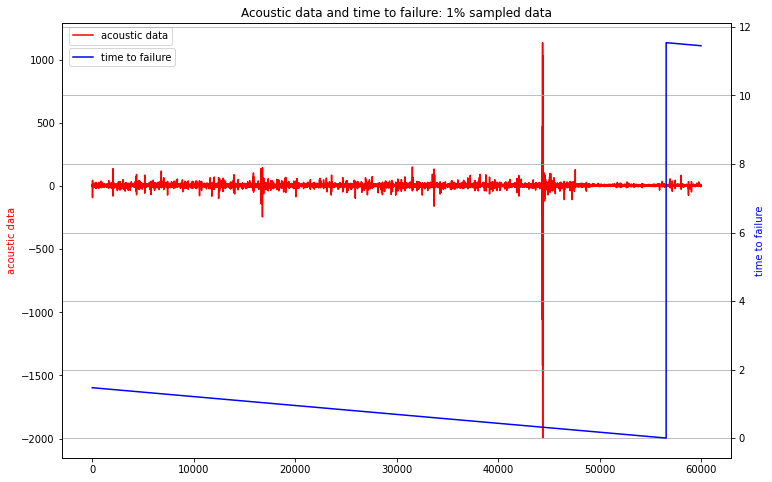

In [23]:
#visualize 1% of samples data, first 100 datapoints
train_ad_sample_df = train['acoustic_data'].values[::100]
train_ttf_sample_df = train['time_to_failure'].values[::100]

#function for plotting based on both features
def plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df, title="Acoustic data and time to failure: 1% sampled data"):
    fig, ax1 = plt.subplots(figsize=(12, 8))
    plt.title(title)
    plt.plot(train_ad_sample_df, color='r')
    ax1.set_ylabel('acoustic data', color='r')
    plt.legend(['acoustic data'], loc=(0.01, 0.95))
    ax2 = ax1.twinx()
    plt.plot(train_ttf_sample_df, color='b')
    ax2.set_ylabel('time to failure', color='b')
    plt.legend(['time to failure'], loc=(0.01, 0.9))
    plt.grid(True)

plot_acc_ttf_data(train_ad_sample_df, train_ttf_sample_df)
del train_ad_sample_df
del train_ttf_sample_df

In [25]:
# Step 4 - Feature Engineering and signifiance of these statistical features

#lets create a function to generate some statistical features based on the training data
def gen_features(X):
    strain = []
    strain.append(X.mean())
    strain.append(X.std())
    strain.append(X.min())
    strain.append(X.max())
    strain.append(X.kurtosis())
    strain.append(X.skew())
    strain.append(np.quantile(X,0.01))
    strain.append(np.quantile(X,0.05))
    strain.append(np.quantile(X,0.95))
    strain.append(np.quantile(X,0.99))
    strain.append(np.abs(X).max())
    strain.append(np.abs(X).mean())
    strain.append(np.abs(X).std())
    return pd.Series(strain)

In [26]:
train = pd.read_csv('train.csv', iterator=True, chunksize=150_000, dtype={'acoustic_data': np.int16, 'time_to_failure': np.float64})

X_train = pd.DataFrame()
y_train = pd.Series()
for df in train:
    ch = gen_features(df['acoustic_data'])
    X_train = X_train.append(ch, ignore_index=True)
    y_train = y_train.append(pd.Series(df['time_to_failure'].values[-1]))
X_train.describe()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: DeprecationWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  after removing the cwd from sys.path.


,0,1,2,3,4,5,6,7,8,9,10,11,12
count,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000,4195.000000
mean,4.519475,6.547788,-149.190942,163.522288,68.297997,0.125830,-11.224603,-2.184779,11.231716,20.321890,170.046246,5.547367,5.750165
std,0.256049,8.503939,265.087984,272.930331,70.532565,0.477901,14.106852,2.346558,2.358067,14.225526,296.887015,1.517038,8.339211
min,3.596313,2.802720,-5515.000000,23.000000,0.648602,-4.091826,-336.000000,-39.000000,9.000000,11.000000,23.000000,4.147707,2.589085
25%,4.349497,4.478637,-154.000000,92.000000,28.090227,-0.040779,-14.000000,-3.000000,10.000000,15.000000,94.000000,5.061843,3.862810
50%,4.522147,5.618798,-111.000000,123.000000,45.816625,0.085620,-10.000000,-2.000000,11.000000,19.000000,127.000000,5.380853,4.781513
75%,4.693350,6.880904,-79.000000,170.000000,78.664202,0.253930,-6.000000,-1.000000,12.000000,23.000000,175.000000,5.748553,5.887947
max,5.391993,153.703569,-15.000000,5444.000000,631.158927,4.219429,-2.000000,0.000000,50.000000,337.000000,5515.000000,32.762073,150.432368


In [36]:
#Model #2 - Support Vector Machine w/ RBF + Grid Search

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.svm import NuSVR, SVR


scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)

parameters = [{'gamma': [0.001, 0.005, 0.01, 0.02, 0.05, 0.1],
               'C': [0.1, 0.2, 0.25, 0.5, 1, 1.5, 2]}]
               #'nu': [0.75, 0.8, 0.85, 0.9, 0.95, 0.97]}]

reg1 = GridSearchCV(SVR(kernel='rbf', tol=0.01), parameters, cv=5, scoring='neg_mean_absolute_error')
reg1.fit(X_train_scaled, y_train.values.flatten())
y_pred1 = reg1.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg1.best_score_))
print(reg1.best_params_)

Best CV score: -2.1722
{'C': 2, 'gamma': 0.02}


In [32]:
model = SVR(kernel='rbf', tol=0.01, gamma=0.02, C=2)
model.fit(X_train_scaled, y_train.values.flatten())
prediction= model.predict(X_train_scaled)
print(prediction)
print(model.score(X_train_scaled, y_train.values.flatten()))


[5.0946711  4.17278294 2.43113838 ... 7.63276908 9.49076648 8.39964459]
0.433868890689708


In [33]:
# another method is KernelRidge Regressor

from sklearn.kernel_ridge import KernelRidge

parameters = [{'gamma': np.linspace(0.001, 0.1, 10),
               'alpha': [0.005, 0.01, 0.02, 0.05, 0.1]}]

reg2 = GridSearchCV(KernelRidge(kernel='rbf'), parameters, cv=5, scoring='neg_mean_absolute_error')
reg2.fit(X_train_scaled, y_train.values.flatten())
y_pred2 = reg2.predict(X_train_scaled)

print("Best CV score: {:.4f}".format(reg2.best_score_))
print(reg2.best_params_)

Best CV score: -2.2046
{'alpha': 0.1, 'gamma': 0.012}


In [34]:
model = KernelRidge(kernel='rbf', gamma=0.012, alpha=0.1)
model.fit(X_train_scaled, y_train.values.flatten())
prediction= model.predict(X_train_scaled)
print(prediction)
print(model.score(X_train_scaled, y_train.values.flatten()))

[5.15135911 4.40527502 2.95736361 ... 7.90833572 9.87272368 8.64438996]
0.45412201785404727


Text(0.5, 1.0, 'Kernel Ridge predictions vs actual')

<Figure size 432x288 with 0 Axes>

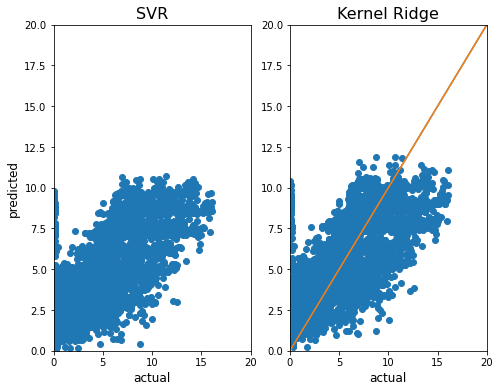

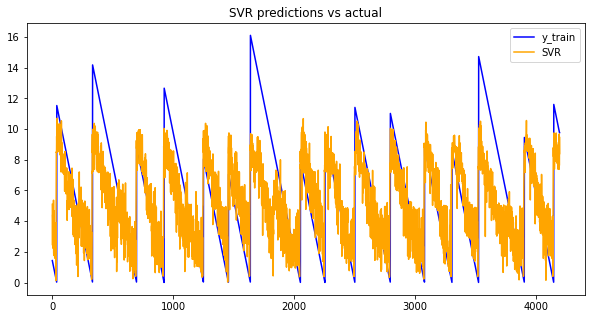

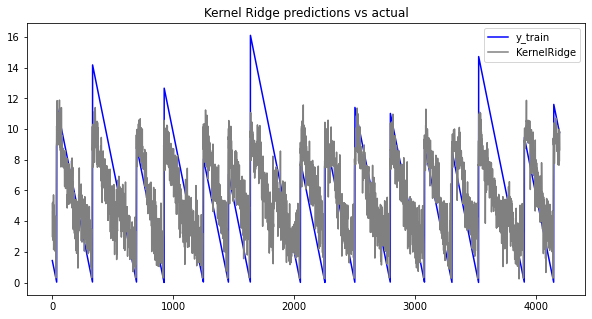

In [38]:
plt.tight_layout()
f = plt.figure(figsize=(12, 6))
f.add_subplot(1, 3, 1)
plt.scatter(y_train.values.flatten(), y_pred1)
plt.title('SVR', fontsize=16)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.ylabel('predicted', fontsize=12)
plt.plot()

f.add_subplot(1, 3, 2)
plt.scatter(y_train.values.flatten(), y_pred2)
plt.title('Kernel Ridge', fontsize=16)
plt.xlim(0, 20)
plt.ylim(0, 20)
plt.xlabel('actual', fontsize=12)
plt.plot([(0, 0), (20, 20)], [(0, 0), (20, 20)])

# second plot
plt.figure(figsize=(10, 5))
plt.plot(y_train.values.flatten(), color='blue', label='y_train')
plt.plot(y_pred1, color='orange', label='SVR')
plt.legend()
plt.title('SVR predictions vs actual')

# third plot
plt.figure(figsize=(10, 5))
plt.plot(y_train.values.flatten(), color='blue', label='y_train')
plt.plot(y_pred2, color='gray', label='KernelRidge')
plt.legend()
plt.title('Kernel Ridge predictions vs actual')
